In [1]:
from category_encoders import MEstimateEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
import xgboost as xgb
import optuna

data = pd.read_csv("train.csv")

c:\Users\Nicholas\AppData\Local\pypoetry\Cache\virtualenvs\kaggle-competitions-i1TPCf8m-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TWF (Tool Wear Failure) indicating industrial tool failure resulting in the need for equipment change and defective products.

HDF (Heat Dissipation Failure) indicating failure in heat dissipation during the production process.

PWF (Power Failure) indicating that the power supplied was not fit to the production process need resulting in a failure.

OSF (Overstain Failure) indicating failure involves product overstains which may be the result of high load and tension during production.

RNF (Random Failure) indicating that a random error causes the failure.


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [3]:
def clean_data(df):
    for col in df:
        df = df.rename(
            columns={
                col: col.lower()
                .replace(" ", "_")
                .replace("[", "")
                .replace("]", "")
                .replace("(", "")
                .replace(")", "")
            }
        )

    return df

In [4]:
data = clean_data(data)


In [5]:
failure_reasons = [
    "twf",
    "hdf",
    "pwf",
    "osf",
    "rnf",
]

In [6]:
data["machine_failure"] = data[failure_reasons].sum(axis=1) > 0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     136429 non-null  int64  
 1   product_id             136429 non-null  object 
 2   type                   136429 non-null  object 
 3   air_temperature_k      136429 non-null  float64
 4   process_temperature_k  136429 non-null  float64
 5   rotational_speed_rpm   136429 non-null  int64  
 6   torque_nm              136429 non-null  float64
 7   tool_wear_min          136429 non-null  int64  
 8   machine_failure        136429 non-null  bool   
 9   twf                    136429 non-null  int64  
 10  hdf                    136429 non-null  int64  
 11  pwf                    136429 non-null  int64  
 12  osf                    136429 non-null  int64  
 13  rnf                    136429 non-null  int64  
dtypes: bool(1), float64(3), int64(8), ob

In [8]:
print(data.machine_failure.value_counts())
print(data.machine_failure.value_counts(normalize=True))

machine_failure
False    134473
True       1956
Name: count, dtype: int64
machine_failure
False    0.985663
True     0.014337
Name: proportion, dtype: float64


In [9]:
data.head()

,id,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,twf,hdf,pwf,osf,rnf
0,0,L50096,L,300.6,309.6,1596,36.1,140,False,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,False,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,False,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,False,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,False,0,0,0,0,0


In [10]:
data.describe()

,id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,twf,hdf,pwf,osf,rnf
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000


[Text(0, 0, '212'),
 Text(0, 0, '704'),
 Text(0, 0, '327'),
 Text(0, 0, '540'),
 Text(0, 0, '308')]

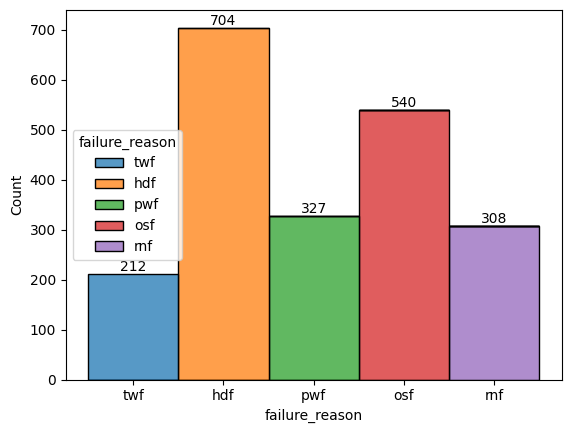

In [11]:
failure_dist = (
    data[failure_reasons]
    .sum()
    .reset_index()
    .rename(columns={0: "count", "index": "failure_reason"})
)

fig = sns.histplot(
    failure_dist,
    x="failure_reason",
    weights="count",
    hue="failure_reason",
    multiple="stack",
)
fig.bar_label(fig.containers[4])


In [12]:
failure_dist


,failure_reason,count
0,twf,212
1,hdf,704
2,pwf,327
3,osf,540
4,rnf,308


<Axes: xlabel='type', ylabel='Count'>

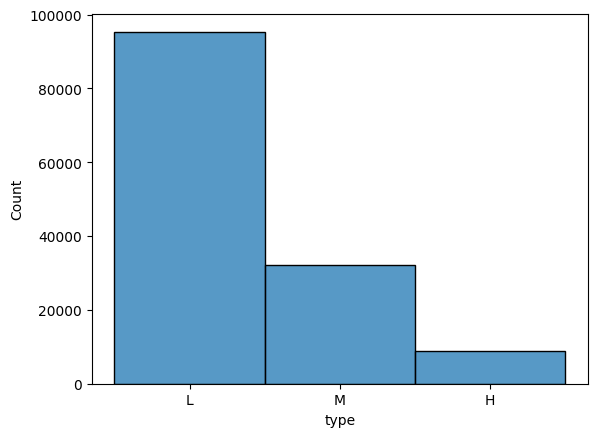

In [13]:
sns.histplot(data, x="type")


In [14]:
product_ids = data.product_id.unique()
product_ids


array(['L50096', 'M20343', 'L49454', ..., 'M18739', 'L50940', 'L48036'],
      dtype=object)

In [15]:
encoder = MEstimateEncoder(cols=["product_id"], m=5)

X = data.drop(columns=["machine_failure"])
y = data.machine_failure

encoder.fit(X, y)
X = encoder.transform(X)

y = y.astype(int)

X.type = X.type.astype("category")

In [16]:
storage = optuna.storages.RDBStorage(
    url="sqlite:///s3e17.db",
)

sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.HyperbandPruner()

study = optuna.create_study(
    study_name="s3e17v1",
    # storage=storage,
    sampler=sampler,
    pruner=pruner,
)


[I 2023-06-25 18:50:24,580] A new study created in memory with name: s3e17v1


In [17]:
def objective(trial):
    test_metric = "auc"

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)
    d_train = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    d_val = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

    params = {
        # "verbosity": 0,
        "objective": "binary:logistic",
        "tree_method": "hist",
        "eval_metric": f"{test_metric}",
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0, 100),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0),
        "alpha": trial.suggest_float(
            "alpha",
            0,
            10.0,
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.1, 1.0),
        "sampling_method": "uniform",  # uniform, gradient_based
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 50),
        "max_bin": trial.suggest_int("max_bin", 10, 2000),
        # "num_parallel_tree": trial.suggest_int("num_parallel_tree", 0, 500),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
    }

    if params["grow_policy"] == "lossguide":
        params["max_leaves"] = trial.suggest_int("max_leaves", 0, 100)
    else:
        params["max_leaves"] = trial.suggest_int("max_leaves", 1, 100)

    if params["booster"] == "dart":
        params["sample_type"] = "uniform"
        params["normalize_type"] = trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        )
        params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0)
        params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0)
        params["one_drop"] = trial.suggest_categorical("one_drop", [True, False])


    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f"val-{test_metric}")
    
    clf = xgb.train(
        params,
        d_train,
        evals=[(d_train, "train"),(d_val, "val")],
        callbacks=[pruning_callback],
        early_stopping_rounds=10,
        num_boost_round=10000,
        verbose_eval=0,
    )
    y_pred = clf.predict(d_val)
    
    auc = roc_auc_score(y_val, y_pred)

    return auc

In [18]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [22]:
study = optuna.create_study(
    study_name="s3e17v1",
    # storage=storage,
    sampler=sampler,
    pruner=pruner,
    direction="maximize",
)


study.optimize(objective, n_trials=1000, show_progress_bar=True, n_jobs=-1)

Best trial: 9. Best value: 1:   6%|▌         | 60/1000 [00:14<03:48,  4.11it/s]      


KeyboardInterrupt: 